In [29]:
import MySQLdb as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline

name = 'DatabaseMain'
conn = db.connect(host = "localhost", user = "root", passwd ="", db=name)
cursor = conn.cursor()

sql = '''SELECT G.DateTime, W.Room, R.Capacity, T.Module, M.NumReg, W.Associated, G.PercentageEstimate, G.BinaryEstimate
FROM DatabaseMain.WiFiLogData W, DatabaseMain.GroundTruth G, DatabaseMain.Rooms R, DatabaseMain.TimeModule T, DatabaseMain.Modules M
WHERE W.Room = G.Room AND W.DateTime BETWEEN G.DateTime AND DATE_ADD(G.DateTime, INTERVAL 1 HOUR) AND R.Room = W.Room AND R.Room = G.Room AND T.Room = G.Room AND T.Room = R.Room AND T.Room =  W.Room AND T.DateTime = G.DateTime AND M.ModuleName = T.Module'''
df = pd.read_sql_query(sql, conn)

In [30]:
df.head()

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate
0,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0
1,2015-11-03 09:00:00,B-003,90,None,0,2,0.00,0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1
3,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0


In [31]:
# http://chrisalbon.com/python/pandas_create_column_using_conditional.html
df['estimate'] = df['Capacity'] * df['PercentageEstimate']
df.head()

,DateTime,Room,Capacity,Module,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
0,2015-11-03 09:00:00,B-002,90,None,0,2,0.00,0,0.0
1,2015-11-03 09:00:00,B-003,90,None,0,2,0.00,0,0.0
2,2015-11-03 09:00:00,B-004,220,COMP41450 & COMP30120,143,62,0.75,1,165.0
3,2015-11-03 09:00:00,B-002,90,None,0,1,0.00,0,0.0
4,2015-11-03 09:00:00,B-003,90,None,0,1,0.00,0,0.0


In [32]:
df.dtypes

DateTime              datetime64[ns]
Room                          object
Capacity                       int64
Module                        object
NumReg                         int64
Associated                     int64
PercentageEstimate           float64
BinaryEstimate                 int64
estimate                     float64
dtype: object

In [33]:
df['Room'] = df['Room'].astype('category')
df['Module'] = df['Module'].astype('category')
df.dtypes

DateTime              datetime64[ns]
Room                        category
Capacity                       int64
Module                      category
NumReg                         int64
Associated                     int64
PercentageEstimate           float64
BinaryEstimate                 int64
estimate                     float64
dtype: object

In [34]:
continuous = df.select_dtypes(['int64', 'float64'])
continous = continuous.corr()
continous

,Capacity,NumReg,Associated,PercentageEstimate,BinaryEstimate,estimate
Capacity,1.000000,0.463803,0.307442,-0.043771,-0.059141,0.391415
NumReg,0.463803,1.000000,0.672959,0.348959,0.290459,0.563652
Associated,0.307442,0.672959,1.000000,0.561168,0.429123,0.697991
PercentageEstimate,-0.043771,0.348959,0.561168,1.000000,0.770780,0.818172
BinaryEstimate,-0.059141,0.290459,0.429123,0.770780,1.000000,0.634112
estimate,0.391415,0.563652,0.697991,0.818172,0.634112,1.000000


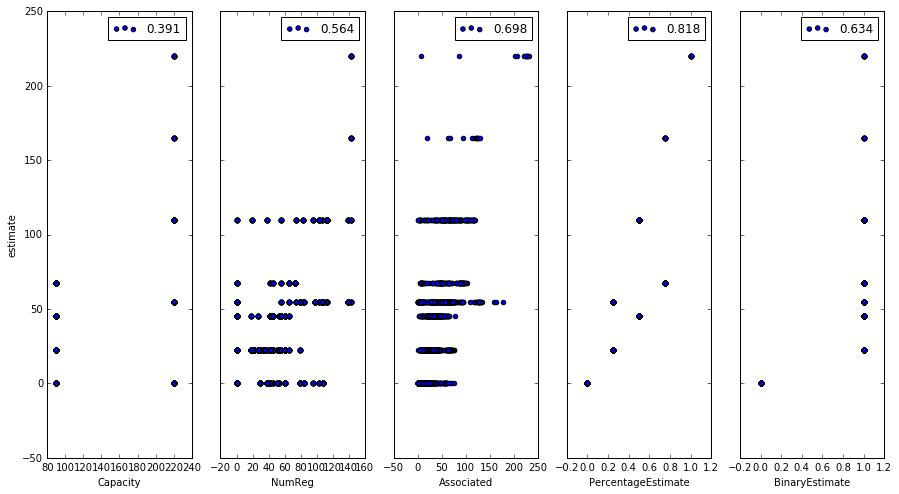

In [50]:
fig, axs = plt.subplots(1, 5, sharey = True)
df.plot(kind='scatter', x = 'Capacity', y = 'estimate', label="%.3f" % df[['Capacity', 'estimate']].corr().as_matrix()[0,1], ax = axs[0])
df.plot(kind='scatter', x = 'NumReg', y = 'estimate', label="%.3f" % df[['NumReg', 'estimate']].corr().as_matrix()[0,1], ax = axs[1])
df.plot(kind='scatter', x = 'Associated', y = 'estimate', label="%.3f" % df[['Associated', 'estimate']].corr().as_matrix()[0,1], ax = axs[2])
df.plot(kind='scatter', x = 'PercentageEstimate', y = 'estimate', label="%.3f" % df[['PercentageEstimate', 'estimate']].corr().as_matrix()[0,1], ax = axs[3])
df.plot(kind='scatter', x = 'BinaryEstimate', y = 'estimate', label="%.3f" % df[['BinaryEstimate', 'estimate']].corr().as_matrix()[0,1], ax = axs[4], figsize =(15,8))


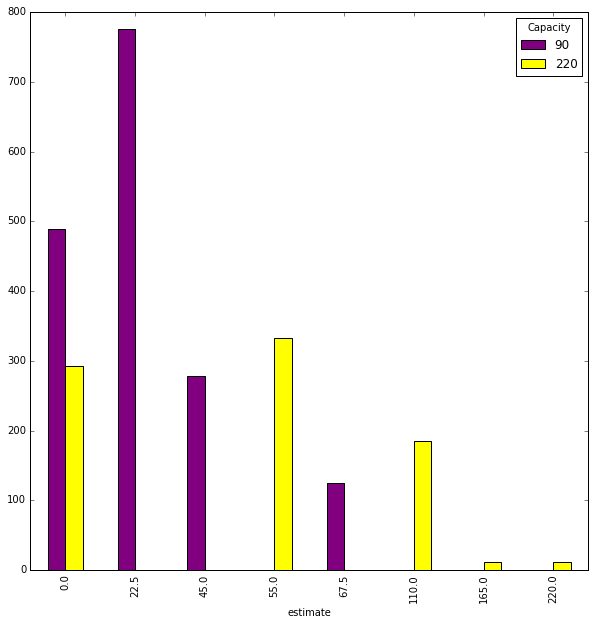

In [55]:
plot_data = pd.crosstab([df.estimate], df.Capacity)
plot_data.plot(kind = 'bar', stacked =False, color=['purple', 'yellow'], grid=False, figsize = (10,10))

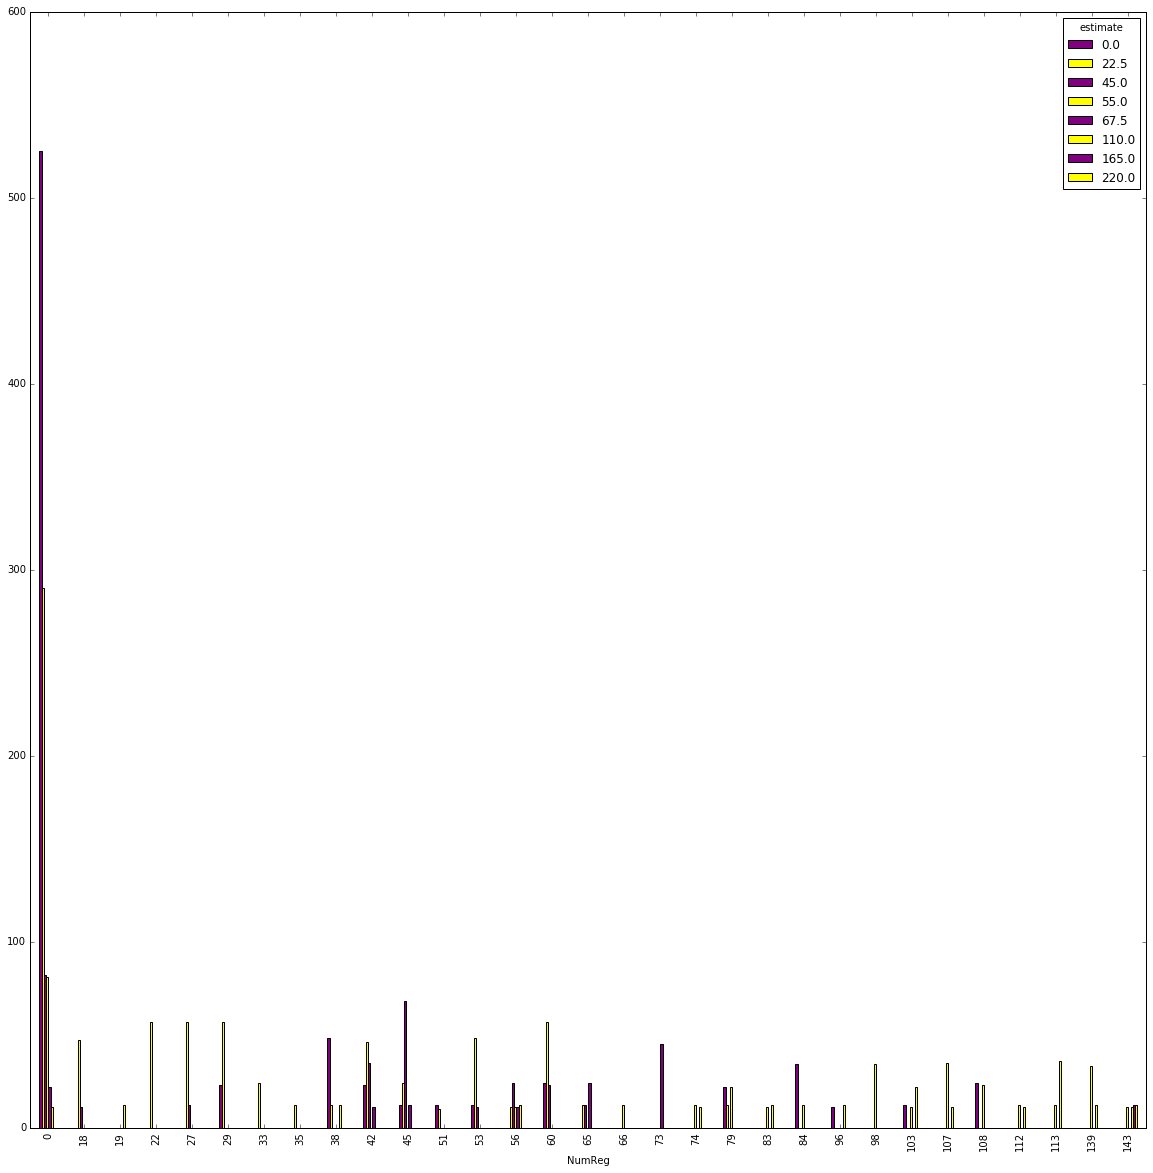

In [58]:
plot_data = pd.crosstab([df.NumReg], df.estimate)
plot_data.plot(kind = 'bar', stacked =False, color=['purple', 'yellow'], grid=False, figsize = (20,20))

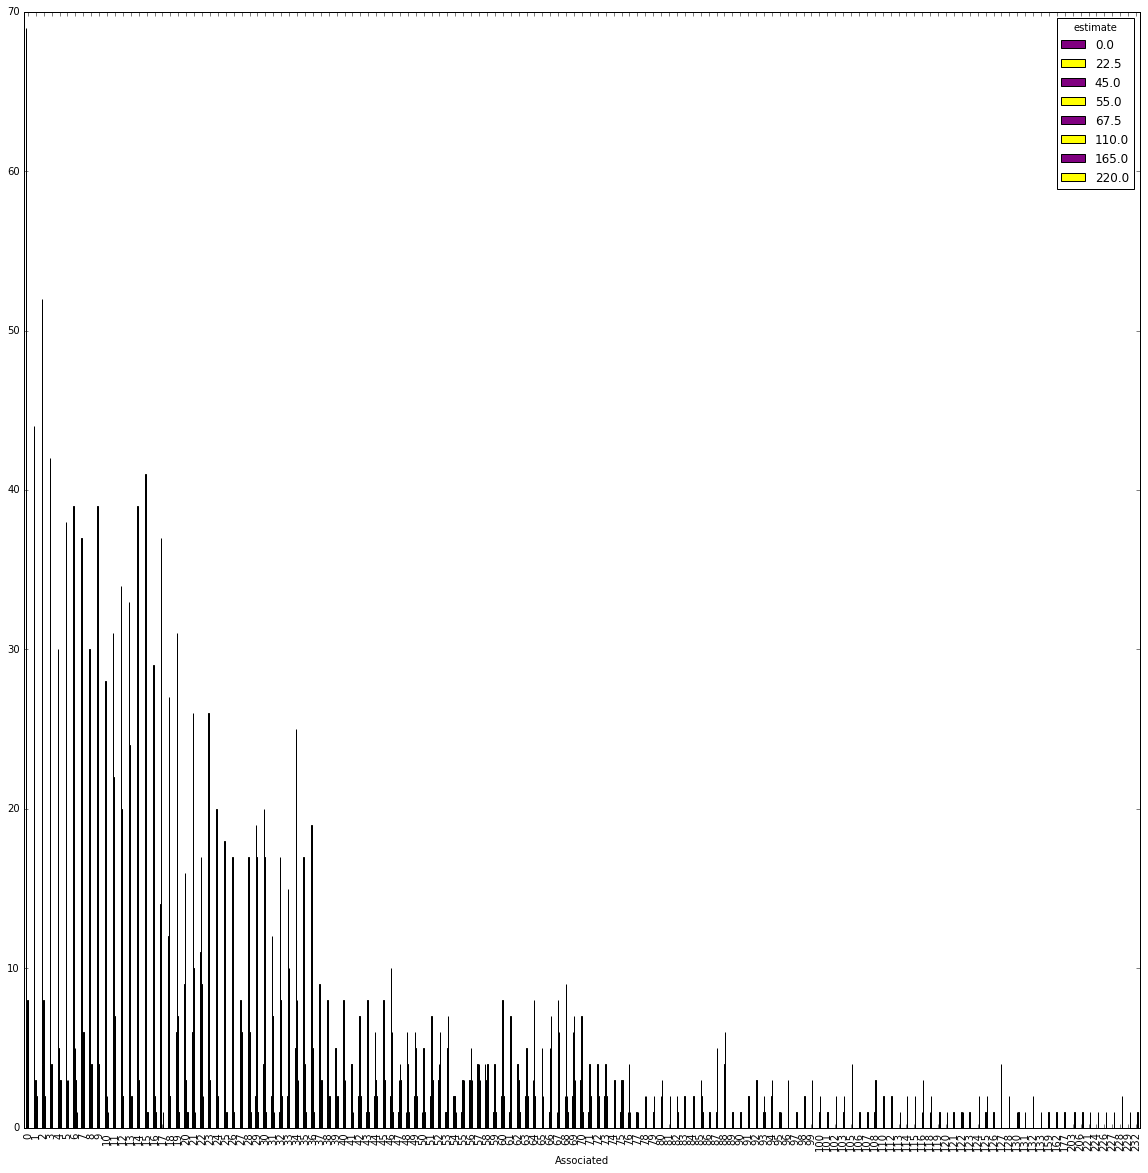

In [60]:
plot_data = pd.crosstab([df.Associated], df.estimate)
plot_data.plot(kind = 'bar', stacked =False, color=['purple', 'yellow'], grid=False, figsize = (20,20))

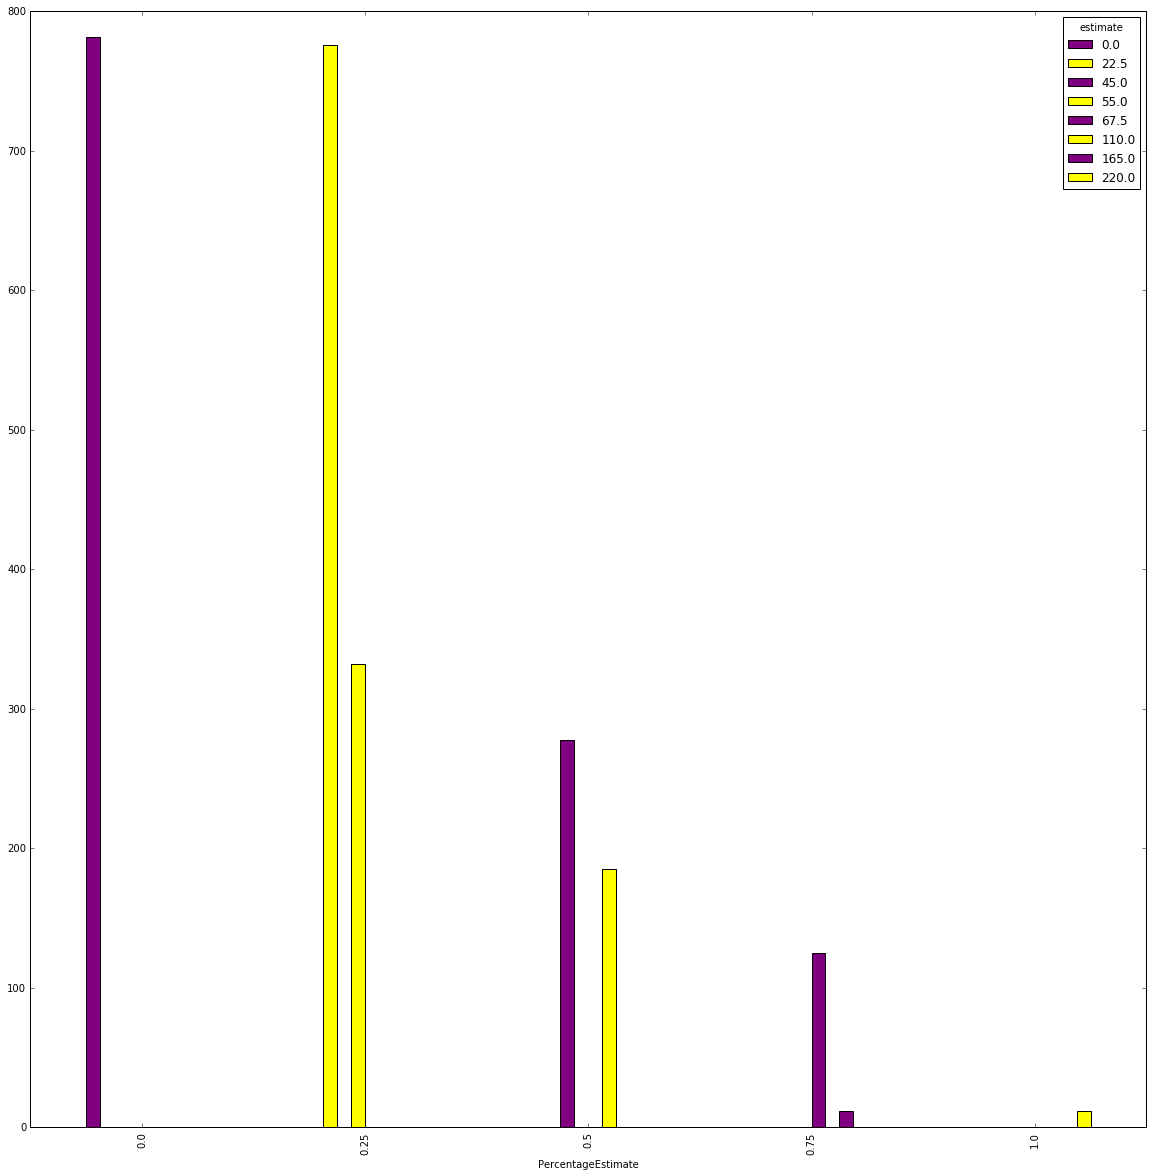

In [61]:
plot_data = pd.crosstab([df.PercentageEstimate], df.estimate)
plot_data.plot(kind = 'bar', stacked =False, color=['purple', 'yellow'], grid=False, figsize = (20,20))

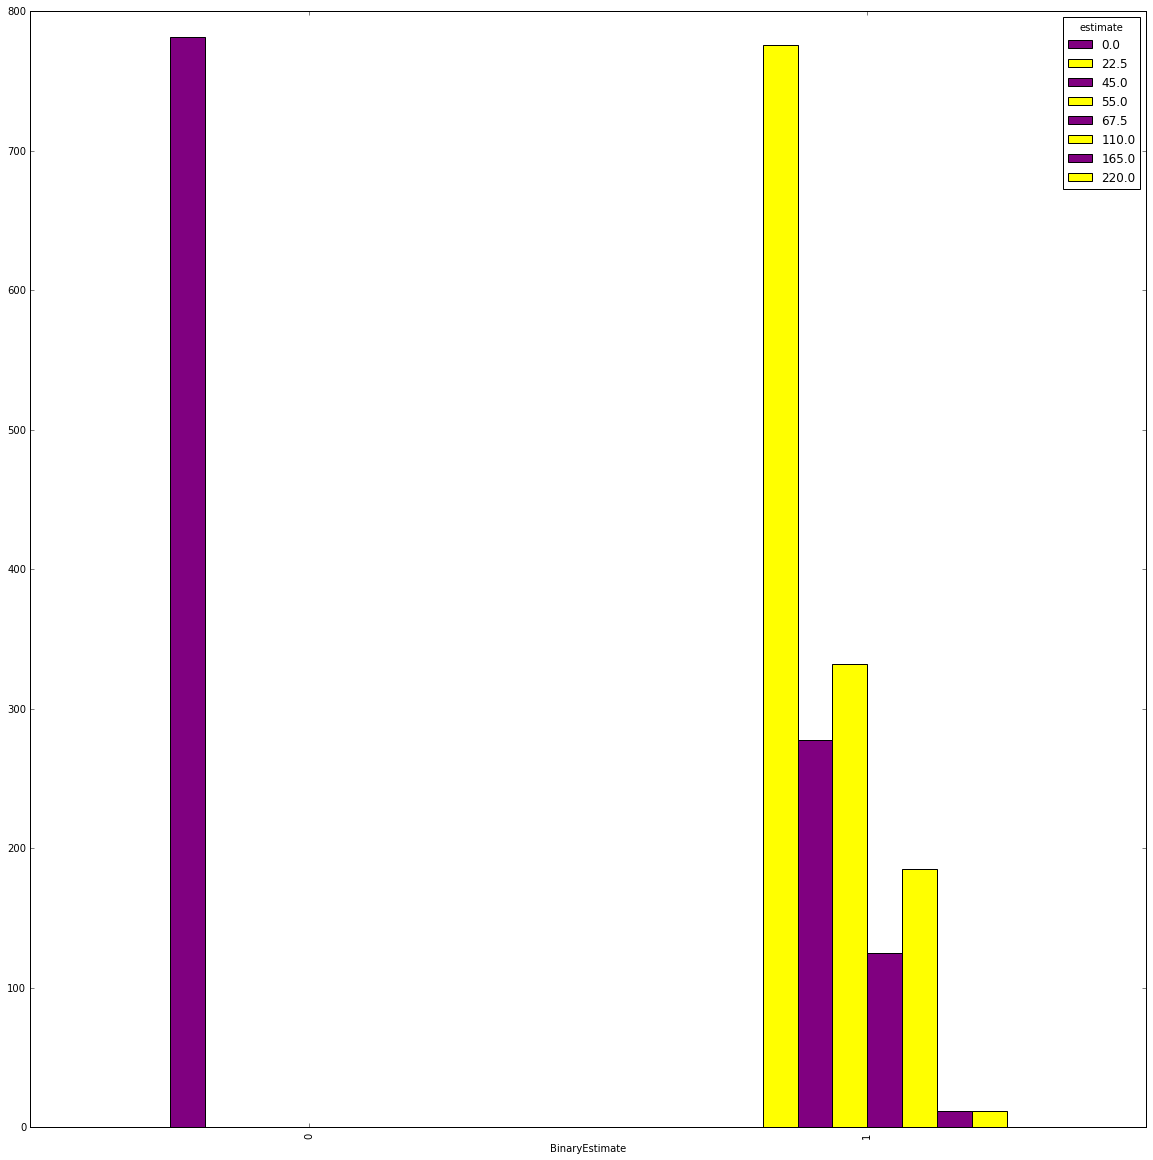

In [62]:
plot_data = pd.crosstab([df.BinaryEstimate], df.estimate)
plot_data.plot(kind = 'bar', stacked =False, color=['purple', 'yellow'], grid=False, figsize = (20,20))

In [68]:
import statsmodels.formula.api as sm

lm = sm.ols(formula = "estimate  ~ Capacity+NumReg+Associated+PercentageEstimate+BinaryEstimate", data = df).fit()
print(lm.params)

Intercept             -31.136633
Capacity                0.204513
NumReg                  0.033459
Associated              0.175247
PercentageEstimate    113.802295
BinaryEstimate          2.269937
dtype: float64


In [69]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     3333.
Date:                Mon, 11 Jul 2016   Prob (F-statistic):               0.00
Time:                        21:49:53   Log-Likelihood:                -9873.9
No. Observations:                2502   AIC:                         1.976e+04
Df Residuals:                    2496   BIC:                         1.979e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            -31.1366      0

In [73]:
lm_cat = sm.ols(formula = "estimate ~ (C(Module) - 1) + (C(Room)-1) + (C(DateTime)-1)", data=df).fit()
print(lm_cat.summary())

                            OLS Regression Results                            
Dep. Variable:               estimate   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     76.63
Date:                Mon, 11 Jul 2016   Prob (F-statistic):               0.00
Time:                        22:02:29   Log-Likelihood:                -10394.
No. Observations:                2502   AIC:                         2.104e+04
Df Residuals:                    2375   BIC:                         2.178e+04
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------

In [82]:
from patsy import dmatrices
from sklearn import metrics
pred = lm.predict(df)
pred


for i in range(0, len(pred)):
    if pred[i] < 

array([ -12.37997949,  -12.37997949,  117.12778239, ...,   18.69102548,
         20.09300385,   13.85620033])

In [83]:
print("Accuracy: ", metrics.accuracy_score(df.estimate, pred))

ValueError: continuous is not supported